<a href="https://www.kaggle.com/code/abhijitdarekar001/training-diffusion-models-on-butterfly-dataset?scriptVersionId=134365925" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h3 style='text-align: center;'>DIffusion Models</h3>

DIffusion Models also knowns as <u>diffusion probabilistic models</u>, are a class of latent variable models.

Diffusion models are deep generative models that work by adding noise (Gaussian noise) to the available training data (also known as the forward diffusion process) and then reversing the process (known as denoising or the reverse diffusion process) to recover the data.

![Diffusion Image](https://learnopencv.com/wp-content/uploads/2023/01/diffusion-models-unconditional_image_generation.gif)

In [2]:
import torch
import torchvision

from torchvision import transforms
from datasets import load_dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import torch.nn.functional as F
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from datasets import load_dataset
from PIL import Image

In [3]:
dataset= load_dataset("huggan/smithsonian_butterflies_subset",split='train')

In [4]:
image_size=64

preprocess=transforms.Compose([
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ])

In [5]:
dataset.set_transform(preprocess)
batch_size=64
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

device="cuda" if torch.cuda.is_available() else "cpu"

In [7]:
def show_images(image):
    plt.imshow(make_grid(image*0.5+0.5).permute(1,2,0))

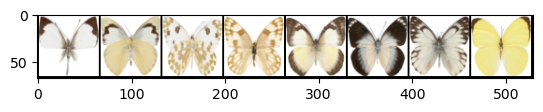

In [8]:
batch=next(iter(train_dataloader))
show_images(batch['images'][:8])

<h4 style='text-align: center;'>U-NET Model</h4>

U-Net is an architecture for semantic segmentation. It consists of a contracting path and an expansive path. <br><br>
First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers.
The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions. <br>
Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

The architecture is as follows,
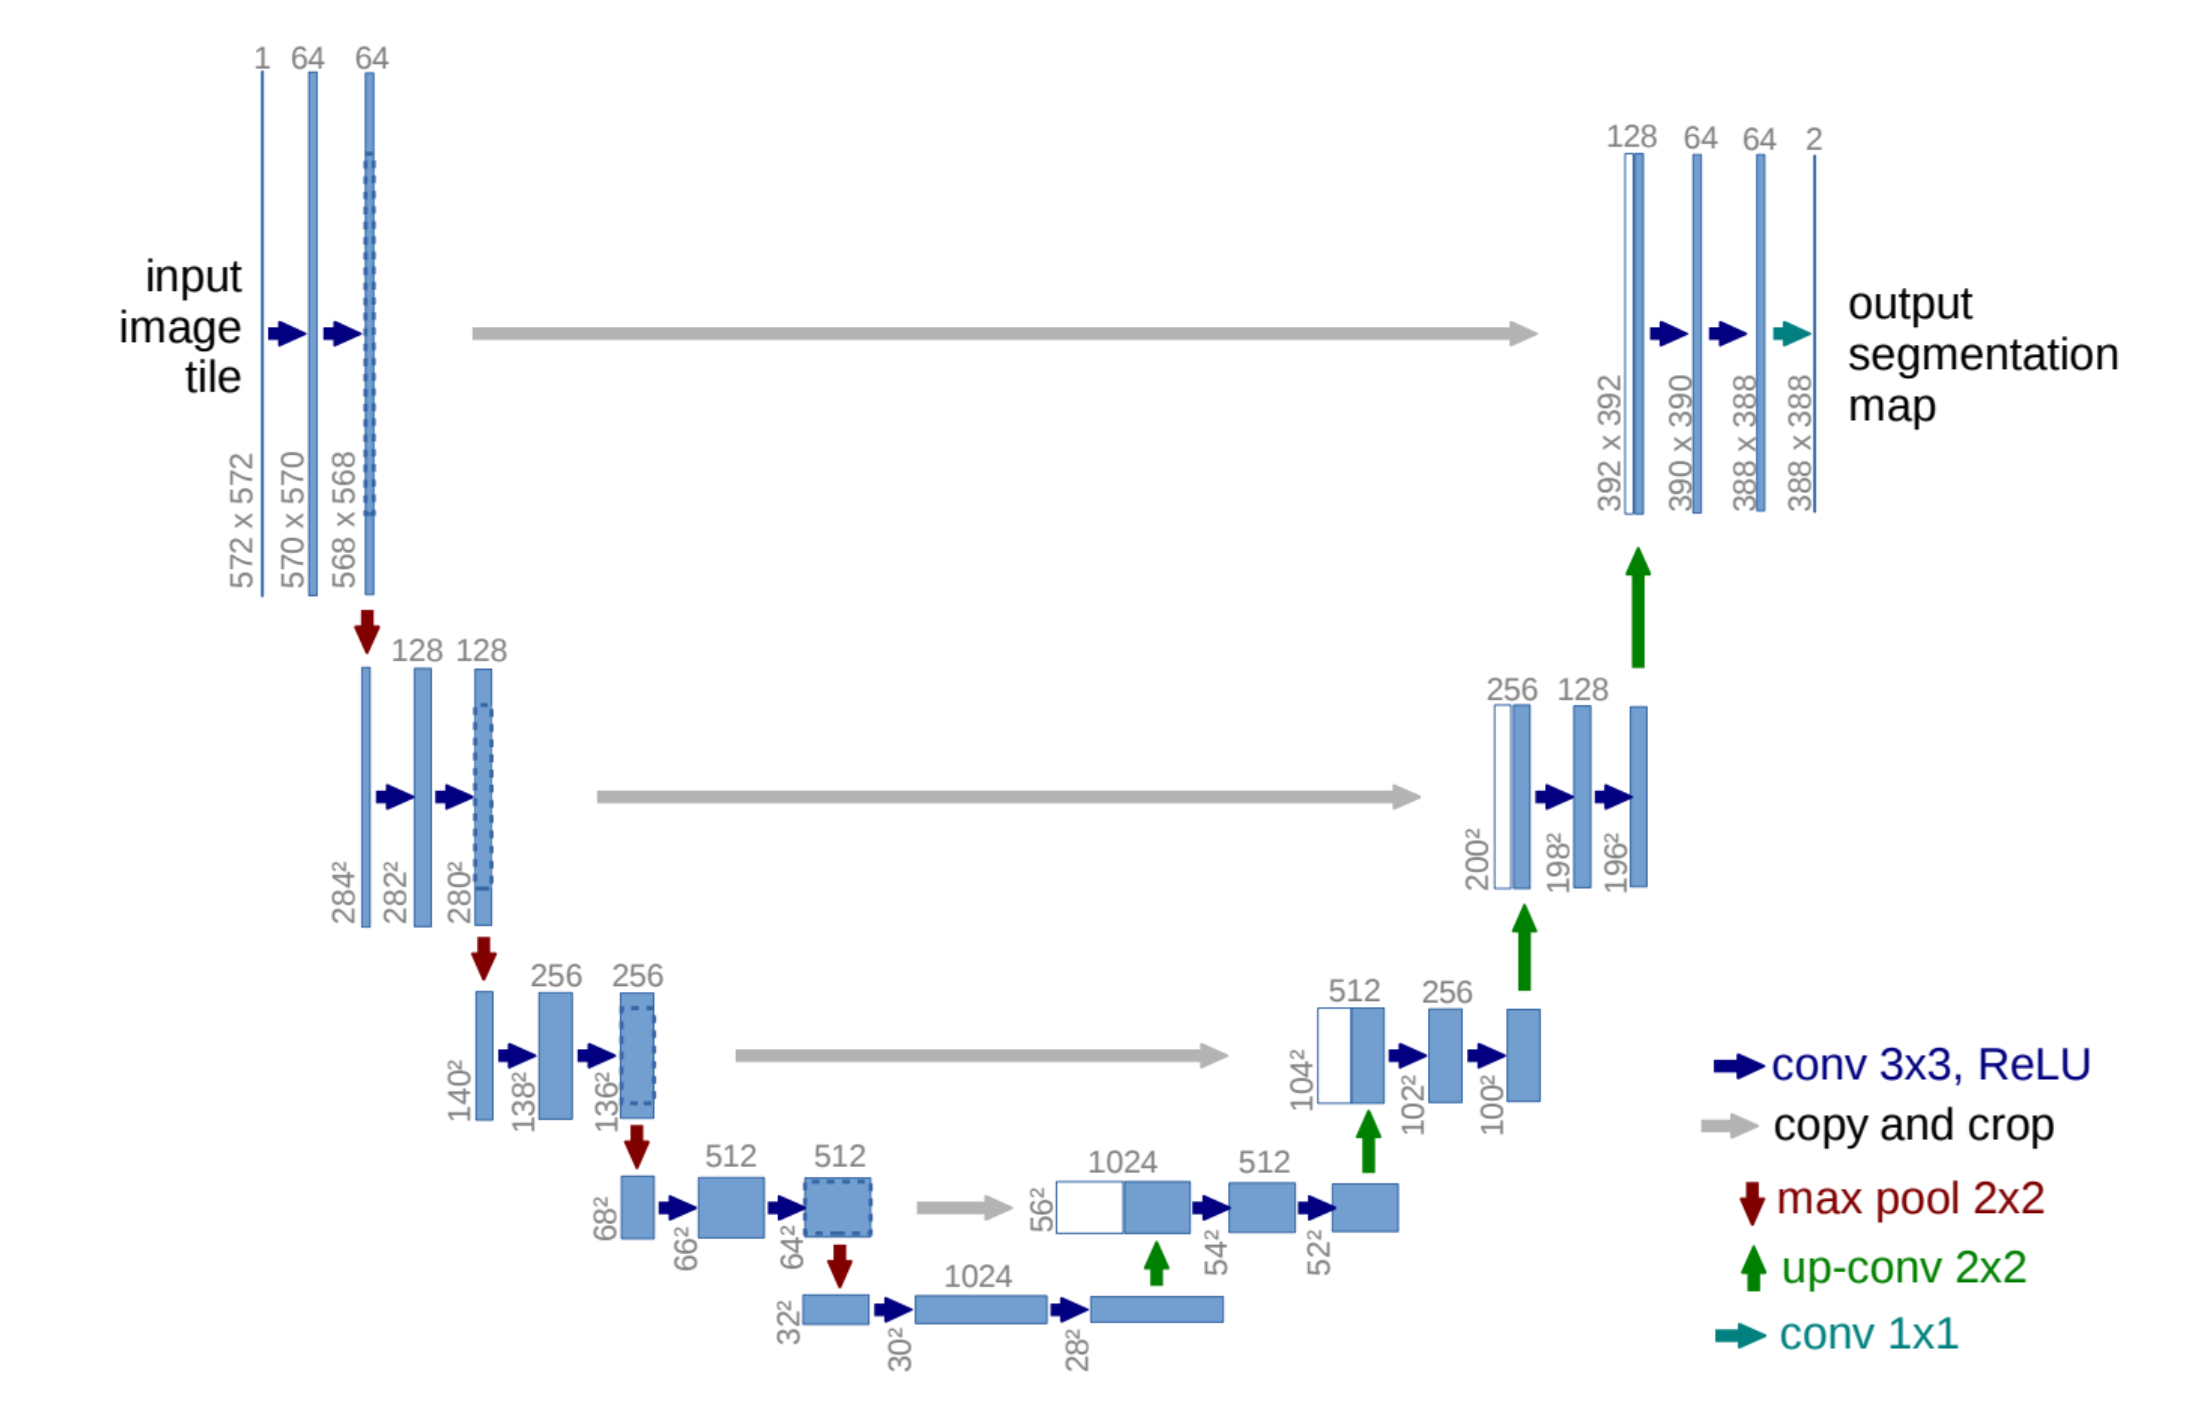

In [9]:
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.02)
model=UNet2DModel(sample_size=64,block_out_channels=(64,128,256,512,512,512,512),
                  down_block_types=('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D',\
                                    'AttnDownBlock2D','AttnDownBlock2D','AttnDownBlock2D',\
                                    'AttnDownBlock2D'),
                   up_block_types=('AttnUpBlock2D','AttnUpBlock2D','AttnUpBlock2D',\
                                   'AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D',\
                                   'UpBlock2D'))

#### Model Training

In [11]:
num_epochs=200
ls=1e-4
model=model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=ls)
losses = []

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):

        clean_images = batch["images"].to(device)

        noise = torch.randn(clean_images.shape).to(clean_images.device)
        timesteps = torch.randint(
            0,
            scheduler.num_train_timesteps,
            (clean_images.shape[0],),
            device=clean_images.device,
        ).long()

        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)

        losses.append(loss.item())
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()
    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1} Loss {loss}")

Epoch 10 Loss 0.05604929104447365
Epoch 20 Loss 0.040986258536577225
Epoch 30 Loss 0.04490331932902336
Epoch 40 Loss 0.02478037402033806
Epoch 50 Loss 0.032957933843135834
Epoch 60 Loss 0.015179396606981754
Epoch 70 Loss 0.025821369141340256
Epoch 80 Loss 0.02999323606491089
Epoch 90 Loss 0.022894784808158875
Epoch 100 Loss 0.012719935737550259
Epoch 110 Loss 0.014876279048621655
Epoch 120 Loss 0.015947356820106506
Epoch 130 Loss 0.020422011613845825
Epoch 140 Loss 0.031991273164749146
Epoch 150 Loss 0.016467832028865814
Epoch 160 Loss 0.015742678195238113
Epoch 170 Loss 0.01789996773004532
Epoch 180 Loss 0.009897272102534771
Epoch 190 Loss 0.014707594178617
Epoch 200 Loss 0.014283870346844196


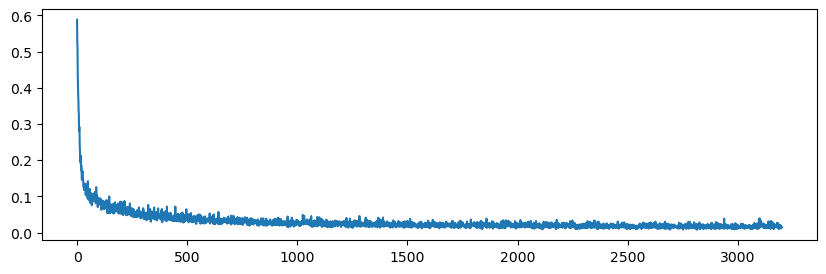

In [12]:
plt.figure(figsize=(10,3))
plt.plot(losses)

In [13]:
from diffusers import DDPMPipeline

pipe= DDPMPipeline(unet=model,scheduler=scheduler)
pipe.to(device)

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.17.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

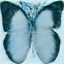

In [14]:
pipe().images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

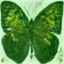

In [15]:
pipe().images[0]